In [1]:
pip install scikit-learn

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
nltk.download('stopwords')
import math
from scipy.stats import norm
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
!python -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)
            Y.append(label)


    return X, Y

In [5]:
class Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=1
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY

        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):

        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=10000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model


    def test(self):
        return self.log_reg.score(self.testX, self.testY)


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

## EDA

In [61]:
# downloading adjudicated data
data = pd.read_csv('adjudicated.csv')
data['original text'] = data['original text'].str.replace('\t', '').str.replace('\n', '')
data.head()

,data point ID,adjudicated,label,original text
0,0,adjudicated,TTA,my boyfriend and I live with my parents. I pay...
1,1,adjudicated,TTA,Hey Reddit! My original post got taken down fo...
2,2,adjudicated,TTA,"To provide context, our daughter is 19 months ..."
3,3,adjudicated,ESH,My husband sprung a very sudden trip on us to ...
4,4,adjudicated,YTA,I'm a little on the fence about this although ...


In [51]:
count_TTA = (data['label'] == 'TTA').sum()
count_ESH = (data['label'] == 'ESH').sum()
count_YTA = (data['label'] == 'YTA').sum()
count_NAH = (data['label'] == 'NAH').sum()
count_INFO = (data['label'] == 'INFO').sum()

print(f"TTA: {count_TTA}")
print(f"ESH: {count_ESH}")
print(f"YTA: {count_YTA}")
print(f"NAH: {count_NAH}")
print(f"INFO: {count_INFO}")

TTA: 211
ESH: 57
YTA: 69
NAH: 149
INFO: 14


It seems that, with our dataset of 500 observations, that the label TTA (they're the asshole) and NAH (no assholes here) are the most prominent, with the other labels being disproportionately dispersed throughout. Since this is logistic regression, making sure that the dataset has a balanced amount of observations per category is important for more accurate categorizations. This is a shortcoming that we could address to improve accuracy in the future. Thus, our model might be due for a method like oversampling. However, we continue on with the labeling, function-defining, and model featurization without this.

In [57]:
# randomizing adjudicated data
randomized_data = data.sample(frac=1, random_state=42).reset_index(drop=True)
randomized_data

,data point ID,adjudicated,label,original text
0,361,adjudicated,YTA,"I found out I had a huge brain tumor in June, ..."
1,73,adjudicated,YTA,"To make a long story very short, I (38M) met m..."
2,374,adjudicated,TTA,I always wondered how people ended up in the s...
3,155,adjudicated,NAH,"My daughter, Rachel 17, has always been a trac..."
4,104,adjudicated,YTA,"My brother (37 M), who is two years older than..."
...,...,...,...,...
495,106,adjudicated,NAH,Here me out first as the title seems to indica...
496,270,adjudicated,YTA,"me (f15) and my sister (f18) are, or were, ver..."
497,348,adjudicated,TTA,My wife (27F) and I (31M) were playing Super M...
498,435,adjudicated,TTA,"For starters, M(22) and my girlfriend F(23) ha..."


In [58]:
# splitting data into train, test, and dev
train_dev, test = train_test_split(randomized_data, test_size=0.2, random_state=42)
train, dev = train_test_split(train_dev, test_size=0.25, random_state=42)

print(f"size of train: {train.shape}")
print(f"size of test: {test.shape}")
print(f"size of dev: {dev.shape}")

size of train: (300, 4)
size of test: (100, 4)
size of dev: (100, 4)


In [59]:
# saving train, test, and dev files as txt files ONLY RUN ONCE
train.to_csv("splits/train.txt", sep='\t',  index=False)

test.to_csv("splits/dev.txt", sep='\t', index=False)

dev.to_csv("splits/test.txt",  sep='\t', index=False)

In [10]:
trainingFile = "splits/train.txt"
devFile = "splits/dev.txt"
testFile = "splits/test.txt"

In [11]:
def run(function, trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    simple_classifier = Classifier(function, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights()

In [14]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

# Feature Selection and Process

## Feature 1: Binary BOW

In [15]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1

    return feats

In [16]:
run(binary_bow_featurize, trainingFile, devFile, testFile)

Test accuracy for best dev model: 0.416, 95% CIs: [0.320 0.512]

ESH	0.126	off
ESH	0.123	yelled
ESH	0.120	mad
ESH	0.120	started
ESH	0.117	how
ESH	0.115	telling
ESH	0.112	seeing
ESH	0.112	only
ESH	0.110	has
ESH	0.108	around

INFO	0.103	over
INFO	0.102	doing
INFO	0.092	agreed
INFO	0.090	two
INFO	0.086	before
INFO	0.077	weeks
INFO	0.074	wants
INFO	0.074	pretty
INFO	0.074	live
INFO	0.072	yell

NAH	0.191	saw
NAH	0.178	these
NAH	0.176	getting
NAH	0.174	've
NAH	0.155	gave
NAH	0.146	want
NAH	0.145	's
NAH	0.144	like
NAH	0.133	find
NAH	0.132	live

TTA	0.211	even
TTA	0.173	things
TTA	0.170	time
TTA	0.159	away
TTA	0.159	another
TTA	0.153	husband
TTA	0.138	came
TTA	0.135	ve
TTA	0.134	as
TTA	0.126	through

YTA	0.163	had
YTA	0.161	here
YTA	0.152	it
YTA	0.146	an
YTA	0.142	done
YTA	0.139	leave
YTA	0.138	m
YTA	0.130	see
YTA	0.117	in
YTA	0.115	do

label	0.078	original
label	0.073	text
label	-0.000	dignify
label	-0.000	phish
label	-0.000	out.
label	-0.000	anymore.
label	-0.000	outing
label	-0.000	importan

Through this Binary BOW classification, the test accuracy is decent, though it is less than half. The issue with BOW is how the words that it is weighing could prove useful for coming up with an accurate classification, but there is no context behind the words at all, just using the sole word. With something like the AITA (Am I the Asshole?) posts, there is a lot of situational context that BOW just doesn't incorporate. Thus, we attempted to provide a bit more through Ngrams.

## Feature 2: Ngrams

In [17]:
def ngram_featurize(text, n=2):
    feats = {}
    words = text.split()
    for i in range(len(words) - n + 1):
        ngram = ' '.join(words[i:i + n])
        feats[f'ngram_{n}_{ngram}'] = 1
    return feats

In [18]:
run(ngram_featurize, trainingFile, devFile, testFile)

Test accuracy for best dev model: 0.406, 95% CIs: [0.310 0.502]

ESH	0.147	ngram_2_of my
ESH	0.121	ngram_2_with him
ESH	0.117	ngram_2_and he
ESH	0.108	ngram_2_him to
ESH	0.107	ngram_2_I think
ESH	0.094	ngram_2_me to
ESH	0.086	ngram_2_this is
ESH	0.081	ngram_2_friends and
ESH	0.081	ngram_2_with her
ESH	0.080	ngram_2_he started

INFO	0.088	ngram_2_is that
INFO	0.082	ngram_2_to my
INFO	0.060	ngram_2_on work
INFO	0.059	ngram_2_yell at
INFO	0.059	ngram_2_to yell
INFO	0.059	ngram_2_Is this
INFO	0.058	ngram_2_so I
INFO	0.055	ngram_2_so she
INFO	0.054	ngram_2_doing this
INFO	0.053	ngram_2_to live

NAH	0.165	ngram_2_that I
NAH	0.123	ngram_2_feel like
NAH	0.122	ngram_2_I feel
NAH	0.118	ngram_2_AITA for
NAH	0.109	ngram_2_At the
NAH	0.109	ngram_2_I have
NAH	0.103	ngram_2_to a
NAH	0.103	ngram_2_want to
NAH	0.101	ngram_2_I did
NAH	0.097	ngram_2_don't want

TTA	0.186	ngram_2_was a
TTA	0.172	ngram_2_to be
TTA	0.160	ngram_2_at me
TTA	0.159	ngram_2_me to
TTA	0.158	ngram_2_I will
TTA	0.154	ngram_2_when s

Choosing to do n-grams, we saw that accuracy did not improve, and went down from 0.416 to 0.406. From the results that display the printed weights, it demonstrates that they were given to relational text (with her, she said, to me, etc.) This could indicate good contextual information, as it can lead to assumptions on who might have initiated the conflict, or which people were responsible for which actions. However, this still lowered accuracy. We had yet to deal with sentiment in any way, which (for determining context in a heated conflict) might be important.

Looking at the ngrams that were considered when n=2, there were a lot of stopwords that were considered for each category, such as "and I" and "to". Perhaps ngrams might work better with this taken into account.

## Feature 3: NER Features

We thought, in order to give more context for the text, to incorporate Name Entity Recognition as one of the features, and use it alongside ngrams. Including information about named entities mentioned in the text, such as person names, organization names, locations, etc. can help capture important entities in the context.

From our perspective, NER tagging could have helped the model in a few ways, such as providing additional semantic information about the text, which might improve the feature representation for the logistic regression model. Entities such as names of people, organizations, or locations could be indicative of the class labels in certain classification tasks. By incorporating NER tagging, the model can capture important contextual information related to named entities, which could be crucial for certain classification tasks. For example, in sentiment analysis, knowing the entities mentioned in a text might influence the sentiment expressed towards them. NER tagging could also have potentially reduced the dimensionality of the feature space by representing entities as categorical variables rather than using the entire text, which is good, sinnce a logistic regression model is categorical in nature.

In [35]:
import spacy

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

def ngram_with_ner_features(text, n=2):
    feats = {}
    # Generate n-gram features
    words = text.split()
    for i in range(len(words) - n + 1):
        ngram = ' '.join(words[i:i + n])
        feats[f'ngram_{n}_{ngram}'] = 1

    # Perform NER tagging
    doc = nlp(text)
    for ent in doc.ents:
        feats[f'ner_{ent.label_}'] = 1

    return feats

In [34]:
run(ngram_with_ner_features, trainingFile, devFile, testFile)

Test accuracy for best dev model: 0.436, 95% CIs: [0.339 0.532]

ESH	0.147	ngram_2_of my
ESH	0.120	ngram_2_with him
ESH	0.116	ngram_2_and he
ESH	0.107	ngram_2_him to
ESH	0.105	ngram_2_I think
ESH	0.092	ngram_2_me to
ESH	0.086	ngram_2_this is
ESH	0.083	ner_ORDINAL
ESH	0.081	ngram_2_friends and
ESH	0.079	ngram_2_with her

INFO	0.088	ngram_2_is that
INFO	0.082	ngram_2_to my
INFO	0.060	ngram_2_on work
INFO	0.059	ngram_2_yell at
INFO	0.059	ngram_2_to yell
INFO	0.059	ngram_2_Is this
INFO	0.057	ngram_2_so I
INFO	0.055	ngram_2_so she
INFO	0.054	ngram_2_doing this
INFO	0.053	ngram_2_to live

NAH	0.161	ngram_2_that I
NAH	0.160	ner_DATE
NAH	0.134	ner_ORG
NAH	0.120	ngram_2_feel like
NAH	0.120	ngram_2_I feel
NAH	0.110	ngram_2_AITA for
NAH	0.107	ngram_2_At the
NAH	0.104	ngram_2_I have
NAH	0.101	ngram_2_to a
NAH	0.100	ngram_2_want to

TTA	0.203	ner_DATE
TTA	0.179	ngram_2_was a
TTA	0.167	ngram_2_to be
TTA	0.156	ngram_2_me to
TTA	0.155	ngram_2_at me
TTA	0.154	ngram_2_I will
TTA	0.153	ngram_2_when she
T

Mentioned above were why we thought NER tagging could help our model. Though it did improve accuracy from where we started, it still didn't improve significantly. This could be for a multitude of reasons. NER tagging algorithms might not always accurately identify entities, leading to noise in the feature space. The misclassification of entities or failure to recognize important entities could introduce errors into the model and decrease its performance. Focusing solely on named entities might have resulted in a loss of important information present in the rest of the text. If the entities themselves didn't provide sufficient discriminative information for the classification task, the model might have missed out on other relevant features. In some cases, certain entity classes might dominate the data, leading to class imbalance issues. This imbalance could affect the model's ability to generalize well to new data, especially if the minority classes are of interest.Finally, incorporating NER tagging adds complexity to the feature engineering process and model training. It requires additional preprocessing steps and might increase the computational cost of the logistic regression model, especially if the text data is large.

Especially in our task, which is very subjective and different to each individual in nature, any of these factors could have lead to the feature not performing as well.

## Feature 4: Ngram w/ TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Adjust ngram_range as needed

def ngram_with_tfidf_features(text):
    feats = {}

    # Generate n-gram features
    ngrams = tfidf_vectorizer.fit_transform([text])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    for i, feature in enumerate(feature_names):
        feats[f'ngram_tfidf_{feature}'] = ngrams[0, i]

    return feats

In [28]:
run(ngram_with_tfidf_features, trainingFile, devFile, testFile)

Test accuracy for best dev model: 0.475, 95% CIs: [0.378 0.573]

ESH	4.005	ngram_tfidf_because
ESH	3.757	ngram_tfidf_was
ESH	2.991	ngram_tfidf_we
ESH	2.731	ngram_tfidf_then
ESH	2.693	ngram_tfidf_her
ESH	2.567	ngram_tfidf_other
ESH	2.554	ngram_tfidf_up
ESH	2.484	ngram_tfidf_him
ESH	2.448	ngram_tfidf_one
ESH	2.382	ngram_tfidf_he

INFO	2.852	ngram_tfidf_to
INFO	2.618	ngram_tfidf_so
INFO	2.374	ngram_tfidf_mom
INFO	1.919	ngram_tfidf_got
INFO	1.848	ngram_tfidf_at
INFO	1.824	ngram_tfidf_donna
INFO	1.824	ngram_tfidf_cindy
INFO	1.596	ngram_tfidf_holly
INFO	1.582	ngram_tfidf_my mom
INFO	1.570	ngram_tfidf_friends

NAH	3.683	ngram_tfidf_is
NAH	3.479	ngram_tfidf_like
NAH	3.462	ngram_tfidf_no
NAH	3.103	ngram_tfidf_emma
NAH	3.056	ngram_tfidf_my parents
NAH	3.021	ngram_tfidf_want
NAH	2.845	ngram_tfidf_of
NAH	2.633	ngram_tfidf_was
NAH	2.551	ngram_tfidf_but
NAH	2.415	ngram_tfidf_and she

TTA	4.793	ngram_tfidf_when
TTA	3.936	ngram_tfidf_be
TTA	3.688	ngram_tfidf_money
TTA	3.583	ngram_tfidf_things
TTA	3.15

TF-IDF was by-far the most successful feature that was included in our logistic regression mode. The test accuracy was the highest out of all of our tested features. We figured this could be for a couple reasons:

TF-IDF assigns weights to terms based on their importance in a document relative to a corpus. This helps in capturing the significance of terms in distinguishing documents and classes. Also, by focusing on important terms and down-weighting common ones, TF-IDF naturally reduces the dimensionality of the feature space. This can help mitigate the curse of dimensionality and improve the efficiency of classification algorithms. TF-IDF features are also relatively easy to interpret, as they directly represent the importance of terms in documents. This interpretability can be useful for understanding the model's behavior and explaining its predictions.

However, the model did have short-comings, with our test accuracy never reaching above 50%. It's possible that, since TF-IDF only considers the frequency of terms in documents and does not capture semantic relationships between words, this could have resulted in the model's inability to understand the meaning of text beyond individual terms. TF-IDF also ignores word-order, treating documents as bags of words, disregarding the order in which words appear. This can be problematic for tasks where word order or context is important, such as sentiment analysis or sequence labeling. The size of the vocabulary used in TF-IDF features can be large, especially with large text corpora. Managing and processing a large vocabulary can increase computational complexity and memory requirements. TF-IDF may also struggle to capture the importance of rare terms that occur infrequently in the corpus. Such terms might not receive sufficient weight even if they are highly discriminative for certain classes. TF-IDF is sensitive to stopwords, which are common words that often carry little semantic meaning (e.g., "the", "and", "is"). Depending on the application, stopwords may or may not be filtered out, which can impact the TF-IDF scores. The next step is to include a stopword feature.

TF-IDF does not consider the contextual information of terms within documents. This limitation can affect the model's ability to capture nuanced meanings or relationships between terms.

In [37]:
import gensim.downloader as api

# Load pre-trained word embeddings
word_vectors = api.load("glove-wiki-gigaword-100")

def word_embedding_features(text):
    feats = {}
    words = text.split()

    # Initialize an empty list to store word embeddings
    embeddings = []

    # Iterate over words in the text
    for word in words:
        # Check if the word exists in the pre-trained embeddings
        if word in word_vectors:
            # If the word exists, add its embedding to the list
            embeddings.append(word_vectors[word])

    # Check if there are any embeddings found
    if embeddings:
        # Calculate the average embedding
        avg_embedding = np.mean(embeddings, axis=0)
        # Add each dimension of the average embedding as a feature
        for i, value in enumerate(avg_embedding):
            feats[f'embedding_{i}'] = value

    return feats

# Example usage:
text = "This is an example sentence for word embedding features"
print(word_embedding_features(text))

[==================================================] 100.0% 128.1/128.1MB downloaded
{'embedding_0': -0.20161125, 'embedding_1': 0.3107254, 'embedding_2': 0.35212186, 'embedding_3': -0.030623376, 'embedding_4': 0.42936122, 'embedding_5': 0.39754876, 'embedding_6': -0.176708, 'embedding_7': 0.0230425, 'embedding_8': -0.12091513, 'embedding_9': 0.18468201, 'embedding_10': -0.06507763, 'embedding_11': -0.1350475, 'embedding_12': 0.112476334, 'embedding_13': 0.035186503, 'embedding_14': 0.27366638, 'embedding_15': 0.094249755, 'embedding_16': 0.25825626, 'embedding_17': -0.062186006, 'embedding_18': -0.16748899, 'embedding_19': 0.28032675, 'embedding_20': 0.029916756, 'embedding_21': -0.29419008, 'embedding_22': 0.011551003, 'embedding_23': 0.16226001, 'embedding_24': 0.37432912, 'embedding_25': 0.016816512, 'embedding_26': 0.08019963, 'embedding_27': -0.268394, 'embedding_28': -0.34400576, 'embedding_29': -0.003960747, 'embedding_30': -0.17848626, 'embedding_31': 0.5320482, 'embedding_32'

In [39]:
def remove_stopwords(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.

    feats = {}
    # BEGIN SOLUTION
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]

    for word in filtered_words:
      word = word.lower()
      if word in feats.keys():
        feats[word] += 1
      else:
        feats[word] = 1

    # END SOLUTION
    return feats

## Other features

We thought specific patterns within the text could help determine their classification. For example, sentence length: the longer the sentences in a text, it could indicate a more passionate, drawn-out, emotional response from the writer. The need to defend oneself could lead to longer sentences, which could in turn implicate someone's guilt. However, we found that this feature was not helpful. This could be due to our own interpretations of what long writing means. For some people, writing shorter could mean they feel less of a need to defend themselves, being less guilty. Others might write less and more generally because they're lying or can't back up what they're saying. The writing styles that exist in the world are so dependent on each individual person, their personalities, and their emotions as they are writing the post. Thus, this could have skewed the accuracy in the test set.

In [29]:
def sentence_length(text):
    # Initialize a dictionary to store features
    feats = {}

    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)

    # Calculate the length of each sentence and store it as a feature
    for i, sentence in enumerate(sentences):
        feats[f'sentence_length_{i+1}'] = len(sentence.split())

    return feats

In [30]:
run(sentence_length, trainingFile, devFile, testFile)

Test accuracy for best dev model: 0.317, 95% CIs: [0.226 0.408]

ESH	0.818	sentence_length_36
ESH	0.536	sentence_length_35
ESH	0.243	sentence_length_20
ESH	0.119	sentence_length_30
ESH	0.044	sentence_length_2
ESH	0.044	sentence_length_13
ESH	0.039	sentence_length_27
ESH	0.037	sentence_length_39
ESH	0.031	sentence_length_23
ESH	0.029	sentence_length_21

INFO	0.485	sentence_length_24
INFO	0.164	sentence_length_17
INFO	0.139	sentence_length_25
INFO	0.055	sentence_length_5
INFO	0.033	sentence_length_6
INFO	0.024	sentence_length_18
INFO	0.023	sentence_length_1
INFO	0.023	sentence_length_8
INFO	0.020	sentence_length_4
INFO	0.016	sentence_length_9

NAH	0.513	sentence_length_37
NAH	0.417	sentence_length_34
NAH	0.294	sentence_length_38
NAH	0.246	sentence_length_31
NAH	0.132	sentence_length_20
NAH	0.103	sentence_length_29
NAH	0.085	sentence_length_27
NAH	0.054	sentence_length_14
NAH	0.045	sentence_length_19
NAH	0.044	sentence_length_21

TTA	0.182	sentence_length_20
TTA	0.181	sentence_length_32
T

In [38]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.
    # at the moment, all 4 of: bag of words and your 3 original features are handed off to the combined model
    # update the values within [bag_of_words, feature1, feature2, feature3] to change this.

    all_feats={}
    for feature in [ngram_with_tfidf_features, remove_stopwords]:
        all_feats.update(feature(text))
    return all_feats

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))

    # Compute the confusion matrix
    y_pred = classifier.log_reg.predict(classifier.devX)
    cm = confusion_matrix(classifier.devY, y_pred)

    # Use ConfusionMatrixDisplay to plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, xticks_rotation="vertical", values_format="d")

    plt.show()

In [45]:
def run_final(function, trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    classifier = Classifier(function, trainX, trainY, devX, devY, testX, testY)
    classifier.train()
    accuracy=classifier.test()

    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))
    print_confusion(classifier)

    classifier.printWeights()

Test accuracy for best dev model: 0.366, 95% CIs: [0.272 0.460]



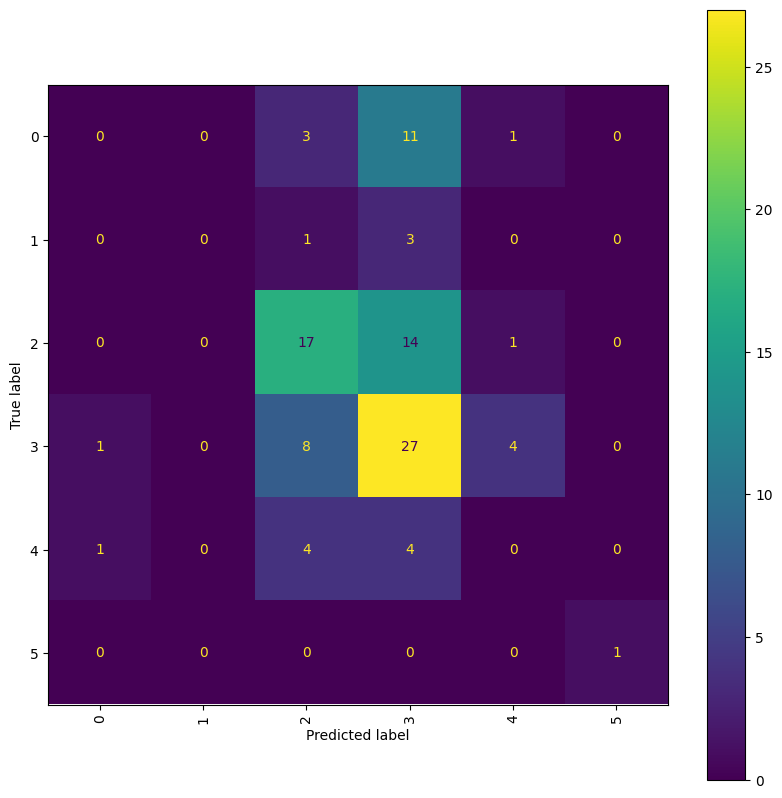

ESH	0.373	started
ESH	0.355	days
ESH	0.304	fun
ESH	0.298	mad
ESH	0.297	headaches
ESH	0.293	gives
ESH	0.287	cops
ESH	0.276	sounds
ESH	0.271	&
ESH	0.271	trip

INFO	0.364	mom
INFO	0.298	permission
INFO	0.257	got
INFO	0.215	back
INFO	0.199	two
INFO	0.195	ask
INFO	0.192	cause
INFO	0.182	even
INFO	0.181	donna
INFO	0.181	cindy

NAH	0.459	joke
NAH	0.422	saw
NAH	0.392	like
NAH	0.363	rude
NAH	0.358	feel
NAH	0.340	christmas
NAH	0.324	juices
NAH	0.320	alcohol
NAH	0.301	space
NAH	0.298	gave

TTA	0.442	things
TTA	0.415	n't
TTA	0.398	mother
TTA	0.359	stay
TTA	0.338	money
TTA	0.335	away
TTA	0.333	well
TTA	0.329	even
TTA	0.323	married
TTA	0.304	could

YTA	0.386	leave
YTA	0.359	sales
YTA	0.306	sasha
YTA	0.303	?
YTA	0.295	kid
YTA	0.289	see
YTA	0.286	asked
YTA	0.280	grace
YTA	0.279	someone
YTA	0.268	person

label	0.197	original
label	0.192	text
label	0.114	ngram_tfidf_original text
label	0.114	ngram_tfidf_original
label	0.113	ngram_tfidf_text
label	-0.000	ngram_tfidf_your ride
label	-0.000	ngram_tfidf_you

In [46]:
run_final(combiner_function, trainingFile, devFile, testFile)

## Interpretation

0 = ESH
1 = INFO
2 = NAH
3 = TTA
4 = YTA
** 5 = label

For the above confusion matrix, we can see that the two labels that were most confused were NAH and TTA, with 22 datapoints (14 + 8) being confused amongst the two. Next is ESH being confused with TTA (11). It seems that the biggest discrepancy was what to label TTA. In TTA, where the person OP is complaining about is in the wrong, it can be confused with a situation where everyone is actually in the wrong (ESH), which makes sense that it didn't predict it as well. The difference between the two boils down to the personal opinions of the annotators/adjudicator and the context of the story, which a computer just simply cannot capture. The same can be said between NAH and TTA. There is clear bias in the poster that, since they are the ones writing, they are the ones that are able to defend themselves and their actions. They have an internal bias that can transfer to their post, where they are most likely to paint themselves in a better light than how the situation might have occurred. This needs to be taken account, and though we did it in our guideline and in our annotation process, it is unclear whether a computer will be able to tell.

** As mentioned in shortcomings, despite our EDA efforts, the name of our label column was incorporated into the model as a label. The reason for this is unknown but it did cost us a datapoint that might have affected our accuracy.

## Discussion/Reflection on Human Annotation Process

In this project’s annotation guidelines, we created a detailed framework for analyzing and labeling posts from the AITA subreddit based on ethical principles and the context of the situations described. The guidelines are quite comprehensive and cover various scenarios to determine whether someone is labeled as YTA, TTA, ESH, NAH, or INFO. To summarize and reiterate the approach:
Understanding the Conflict: Start by identifying the conflict and the parties involved (OP and the other party).
Assessing Ethical Rules: Determine if any ethical or moral rules (like Fidelity, Reparations, Gratitude, Justice, Beneficence, Self-improvement, Non-maleficence) have been violated by either party.
Analyzing the Aftermath: Consider how each party responds or tries to resolve the conflict. Did they attempt to fix the situation, show empathy, or understand the opposing perspective?
Deciding Labels:
YTA (You’re the Asshole): If the OP is clearly in the wrong based on the ethical guidelines.
TTA (They are the Asshole): If the other party is primarily at fault.
ESH (Everyone Sucks Here): If both parties are equally responsible or if their actions have significant consequences.
NAH (No Assholes Here): If neither party is at fault or if their actions are justified given the circumstances.
INFO (Didn’t provide enough context): If more information is needed to make a decision.
Considering Gray Areas: Acknowledge biases, differing moral compasses, and the severity of actions while making judgments.
This systematic approach ensures a fair and thorough analysis of each scenario presented in the AITA posts. It requires careful consideration of the context, ethical principles, parties involved, and the aftermath of the conflict to arrive at an appropriate label for the situation. We believe these guidelines were comprehensive enough to cover most potential scenarios and we took careful consideration into addressing ambiguous situations that might arise in the data. That being said, we do want to acknowledge that subjectivity and interpretation still may have played a part in our annotation process. Annotating text for classification involves subjective judgment, as individuals may interpret scenarios differently. This subjectivity can influence the creation of guidelines and the labeling consistency across annotators. Overall, there was a pretty high level of agreement amongst the three annotators. Most of our labeling decisions were consistent, with around ¼ of them being different. However, the adjudicator was always able to agree with one of the labels from the two annotators for each Reddit post.

When we first began annotating, we had considered only using the labels YTA, NAH, and INFO. However, after reading through some of the exploration batch, we realized that these three labels were not enough to cover all the possible cases as there were many times when both parties could be assholes or the opposing party is the asshole. Therefore, we created the new labels of ESH and TTA to cover these scenarios. When reading the posts, we also began by just reading each one through from start to finish and deciding on a label after that, however we also realized that this method made it very hard to judge each post consistently. Therefore, we decided that we should define the conflict and the aftermath of each case, and use what happens in both parts of the story to process through it and decide on a label. Having a distinct conflict and aftermath also greatly helped us figure which of the parties were being assholes as we were able to decide on what makes someone an asshole based on what they do in the conflict and how they react in the aftermath. Both of these changes improved the quality and reliability of the annotated dataset. Overall, the process of reading 500 different reddit posts was relatively time-consuming as we had to think about and process each of the posts we read to decide on the label. Careful consideration was made for each labeling decision and all parties of each post were looked at and analyzed to make a final decision.


## Weaknesses/Shortcomings and Future Work

For some possible weaknesses and shortcomings of each feature method individually, for Binary-Bag–of-Words (BOW) there could be some loss of sequence information as BOW disregards the order of words and treats each document as a set of independent words. This can lead to the loss of important sequential information and context, which is crucial for understanding meaning. Also, in large vocabularies or datasets with many unique words, BOW can result in sparse matrices, making it challenging to train models effectively without overfitting or underfitting. For NGrams, while it is able to capture local word sequences, it might not generalize well to unseen combinations of words or longer contexts and may capture specific phrases or sequences that are context-dependent, leading to a lack of flexibility in representation of text. And finally for NER, relevance of named entities to the classification task is very important and extracting too many entities can possibly introduce noise into the feature set. Overall, the weaknesses and shortcomings of these feature methods show the challenges in effectively representing and understanding textual data for classification tasks. Each method has specific limitations related to its approach to text representation, context understanding, and generalization capabilities. To address these limitations, we thought it would be beneficial to combine multiple feature methods, which is what we tried to do, however these are still valid limitations overall.

We chose the logistic regression model for our task as we believed it most accurately fit our project and would provide interpretable results by directly estimating the probability of a certain class given the input features. This makes it easy to understand which features contribute positively or negatively to each class prediction. Logistic regression is also computationally efficient, particularly with large sparse feature spaces common in text data. It can handle a large number of features without requiring extensive computational resources. We also explored the BERT model. However, we believe that because the number of data points was too low, this caused our BERT model to provide lower accuracy scores than logistic regression, therefore, we stuck with logistic regression as our model. Our dataset is pretty balanced. None of our labels were extremely prevalent compared to the other ones, so we don’t believe this caused any issues.

Another possible shortcoming is that we used accuracy alone as an evaluation metric. Exploring precision, recall, and F1-score as evaluation metrics might have allowed for a more nuanced evaluation, and helped identify areas of improvement. Precision and recall can help understand the types of errors our model is making and F1-score can help find a balance in these metrics and optimize both precision and recall simultaneously.

As for future directions, some possible avenues for improvement are incorporating external knowledge sources to enhance model robustness and generalization and data augmentation and adversarial training. Integrating external knowledge graphs relevant to the task domain can provide additional contextual information. This would help improve model understanding and decision-making. Utilizing semantic embeddings derived from external sources (e.g., WordNet, ConceptNet) can also enrich feature representations and aid in capturing nuanced semantic relationships. As for data augmentation, applying synthetic data generation techniques (e.g., back-translation, paraphrasing) can increase the diversity and quantity of training data, thereby improving model generalization. Adversarial examples can be generated to train models to be robust against perturbations and adversarial attacks, enhancing model robustness and resilience.

This model we developed could be leveraged in various ways to address real-world problems and applications in the future. For example, it could be used for automated content moderation on social media platforms, forums, or other online communities. It can be modified to help identify and flag inappropriate, offensive, or spammy content efficiently. This model can also be used to analyze certain types of customer feedback, such as reviews or survey responses to categorize sentiments and extract insights. In general, this text classification model can serve as a foundational component that can be adapted, enhanced, or integrated with other technologies to address specific needs and requirements.
